### Assess the water us efficiency of different SP runs. 

### Concatenate a year of output files to speed things up. 

In [1]:
import os
import netCDF4 as nc4
import sys
import os
import shutil

import numpy as np
import warnings
import xarray as xr
from matplotlib import pyplot as plt
import datetime
import os.path
import xesmf as xe

from multiprocessing.pool import ThreadPool
import dask
dask.config.set(scheduler='single-threaded')

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%bash -s 

echo $OMP_NUM_THREADS

echo $OMP_NUM_THREADS

1
1


In [3]:
runs = ['seb_CLM5-SP-noluna_nodl_BB_noPHS_vcm50','seb_CLM5-FATES-smo_vcm50_cl1']
runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop','seb_CLM5-FATES-smo_vcm50_opt_nocrop']
#runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl_noSAI','seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI']
fates=[0,1]
ncases=2

fg=42

forcerundir=[0,0]
if(fg==-6):
        runs = ['clm5-fates_snowcan_cont','clm5-fates_snowcan_test']
        runlabel=['cont','cansnow']
        fates=[1,1]   
if(fg==-5):
        runs = ['sai_errocheck3','sai_errocheck1']
        runlabel=['saierror3','saierro4']
        fates=[1,1]
if(fg==-4):
        runs = ['sai_revert1','sai_revert2']
        runlabel=['sai_opt(2)','sai gpp(2)']
        fates=[1,1]
if(fg==-3):
        runs = ['clm5-fates_SAI_main','sai_revert1']
        runlabel=['main','sai bugfix']
        fates=[1,1]
                
if(fg==-2):
        runs = ['clm5-fates_SAI_main','clm5-fates_SAI_leafprop']
        runlabel=['main','SAIbugfix']
        fates=[1,1]
if(fg==-1):
        runs = ['seb_CLM5-FATES-def','seb_27may_CLMFATESSP_IFPcheck']
        runs = ['seb_CLM5-FATES-def','FATESSP_IFP_issue_test2']
        runlabel=['FATES-SP:default','CLM5-FATES-2june_IFP']
        fates=[1,1]
if(fg==0):
        runs = ['seb_CLM5-SP_def','seb_CLM5-FATES-def']
        runlabel=['CLM5SP:default','FATES-SP:default']
if(fg==1):
        runs = ['seb_CLM5-SP-noluna_nodl_BB_noPHS_vcm50','seb_CLM5-FATES-smo_vcm50_cl1']
        runlabel=['CLM5SP:vcm50','FATES-SP:vcm50']
if(fg==2):
    runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt','seb_CLM5-FATES-smo_vcm50_opt']
    runlabel=['CLM5SP:opt','FATES-SP:opt']
if(fg==3):
    runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop','seb_CLM5-FATES-smo_vcm50_opt_nocrop']
    runlabel=['CLM5SP:nocrop','FATES-SP:nocrop']
if(fg==4):
    runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl_noSAI','seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI']
    runlabel=['CLM5SP:noSAI','FATES-SP:noSAI']
if(fg==4.5):
    runs = ['seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_rad','seb_CLM5-FATES-smoW_vcm50_opt_nocrop_noSAI_dlai_rad']
    runlabel=['smoR','smoW']
    fates=[1,1]
if(fg==5): 
    runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl_noSAI','seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_rad']
    runlabel=['CLM5SP:noSAI','FATES-SP:dLAI0.2']
if(fg == 6):
    runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl_noSAI','seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_elaigs']
    runlabel=['CLM5SP:noSAI','FATES-SP:elai_gs']
if(fg == 7):
    runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl_noSAI','seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_snow']
    runlabel=['CLM5SP:noSAI','FATES-SP:snow']  
if(fg == 8):
    runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl_noSAI','seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_rad']
    runlabel=['CLM5SP:noSAI','FATES-SP:rad']   
if(fg == 9): #impact of new sai bugfix
    runs = ['seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_rad','seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_rad_sai_bugfix']
    runlabel=['FATES-SP:rad','CLM5SP:saseb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAIibugfix']
if(fg == 10): #impact of altered smoothing
    runs = ['seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_rad_sai_bugfix','seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI_dlai_rad_sai_bugfix_smo2']
    runlabel=['FATES_SP:saibugfix','FATES_SP_smo2']
    fates=[1,1]
if(fg == 11):
    runs = ['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl','nov_CLM5-FATES-smo-opt-vcm50']
    runlabel=['CLM5SP','FATES-SP:nov']
    fates=[0,1]
if(fg == 12): #impact of altered smoothing
    runs = ['seb_CLM5-FATES-smo2','seb_CLM5-FATES-smo3']
    runlabel=['tcj: 0.98,0.8. tip:0.97','tcj: 0.98,0.8. tip:0.95']
    fates=[1,1]
if(fg == 13): #impact of altered smoothing
    runs = ['seb_CLM5-FATES-def','seb_CLM5-FATES-smo']
    runlabel=['tcj: 0.999,0.999. tip:0.999','tcj: 0.8,0.98. tip:0.95']
    fates=[1,1]
if(fg == 14): #impact of theta_ip = 0.98
    runs = ['seb_CLM5-FATES-smo7','seb_CLM5-FATES-smo2']
    runlabel=['tcj: 0.99,0.999. tip:0.999','tcj: 0.999,0.99. tip:0.98']
    fates=[1,1]
if(fg == 15): #impact of tcj(0 and 1)
    runs = ['seb_CLM5-FATES-smo7','seb_CLM5-FATES-smo3']
    runlabel=['tcj: 0.999,0.999. tip:0.999','tcj: 0.999,0.98. tip:0.999']
    fates=[1,1]
if(fg == 16): #impact of tcj(1)
    runs = ['seb_CLM5-FATES-smo7','seb_CLM5-FATES-smo4']
    runlabel=['tcj: 0.999,0.999. tip:0.999','tcj:  0.98 0.98  tip; 0.98']
    fates=[1,1]
if(fg == 17): #impact of tcj(0)
    runs = ['seb_CLM5-FATES-smo7','seb_CLM5-FATES-smo5']
    runlabel=['tcj: 0.98,0.8. tip:0.999','tcj: 0.999,0.8. tip:0.999']
    fates=[1,1]
if(fg == 18): #impact of tcj(0)
    runs = ['seb_CLM5-FATES-def','seb_CLM5-FATES-smo6']
    runlabel=['tcj: 0.999,0.999. tip:0.999','tcj: 0.98,0.999. tip:0.9999']
    fates=[1,1]
if(fg == 19): #check default run gives def answers. 
    runs = ['seb_CLM5-FATES-smo7','seb_CLM5-FATES-smo4']
    runlabel=['tcj: 0.999,0.999. tip:0.999','tcj: 0.99,0.999. tip:0.9999']
    fates=[1,1]
    
if(fg==20):
    runs = ['seb_CLM5-FATES-def','greg_sp_test1']
    runlabel=['def','greg_sp_test1']
    fates=[1,1]
if(fg==21):
    runs = ['seb_CLM5-FATES-def','greg_sp_test2']
    runlabel=['def','greg_sp_test4']
    fates=[1,1]  
if(fg==22):
    runs = ['seb_CLM5-SPfates-def_rewindtest0','greg_sp_test4']
    runlabel=['nov_PR','current_PR']
    fates=[1,1]    
if(fg==23):
    runs = ['seb_CLM5-SPfates-def_rewindtest0','greg_sp_test_nosai']
    runlabel=['nov_PR','current_PR no SAI']
    fates=[1,1]  
if(fg==24):
    runs = ['seb_CLM5-SPfates-def_rewindtest0','SPtag_24aug21_test1']
    runlabel=['nov_PR','current_PR no SAI']
    fates=[1,1]
if(fg==25):
    runs = ['SPtag_24aug21_TLAI5','SPtag_24aug21_test1']
    runlabel=['tlai=5','current_PR']
    fates=[1,1]  
if(fg==26):
    runs = ['SPtag_24aug21_TLAI5_HTOP20','SPtag_24aug21_test1']
    runlabel=['tlai=5 HTOP=20','current_PR']
    fates=[1,1]     
if(fg==27):
    runs = ['gregtest_sep2_CLM5-SP_def','seb_CLM5-SP_def']
    runlabel=['tlai=5 HTOP=20','current_PR']
    fates=[0,0] 
     
if(fg==28):
    runs = ['seb_CLM5-SPfates-def_rewindtest0','greg_sp_test_sep2_ws']
    runlabel=['nov_PR','current PR +nploop']
    fates=[1,1]      
    
if(fg==29):
    runs = ['greg_sp_test_sep2','greg_sp_test_sep2_ws']
    runlabel=['current PR','current PR +nploop']
    fates=[1,1]  
    
if(fg==30):
    runs = ['greg_sp_test_sep2_ws','index_0verflow']
    runlabel=['current PR','current PR +nploop']
    fates=[1,1]  
    
if(fg==31):
    runs = ['test_sp_saifix_master','test_sp_saifix_fleaf1']
    runlabel=['master','test fleaf=1']
    fates=[1,1]  
    
if(fg==32):
    runs = ['test_sp_saifix_master','test_sp_saifix']
    runlabel=['master','SAI branch']
    fates=[1,1] 
  
if(fg==33):
    runs = ['test_sp_saifix','test_sp_saifix_nosnow']
    runlabel=['SAI branch','no snow changes']
    fates=[1,1]
    
if(fg==34):
    runs = ['test_sp_saifix','test_sp_saifix_fabs']
    runlabel=['SAI branch','SAI branch fabs change']
    fates=[1,1]
if(fg==35): # test of the impact of removing SAI in CLM5SP
    runs=['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl-nosai','CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl']
    runlabel=['accl','nosai']
    fates=[0,0]   

if(fg==36): # test of the impact of removing SAI in FATES
    runs=['nov_CLM5-FATES-smo-opt-vcm50','nov_CLM5-FATES-buildtest']
    runlabel=['accl','nosai']
    fates=[1,1]   
    
if(fg==37): # test of the old code vs sai0 in new code. 
    runs=['seb_CLM5-FATES-vcmfix_wC4_sla_lcn_smo_opt_nocrop-noSAI','nov_CLM5-FATES-buildtest']
    #runs=['seb_CLM5-FATES-smo_vcm50_opt_nocrop_noSAI','nov_CLM5-FATES-buildtest']
    runlabel=['old code no sai','new code no sai']
    fates=[1,1] 
    forcerundir=[0,0]
        
if(fg==38): # test of no SAI new FATES code vs no SAI CLM5 code. 
    runs=['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl-nosai','nov_CLM5-FATES-buildtest']
    forcerundir=[0,1] 
    runlabel=['CLM5 no SAI','new code no sai']
    fates=[0,1] 
    
if(fg==39): # test of CLM5 vs old no SAI FATES code
    runs=['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl-nosai','seb_CLM5-FATES-vcmfix_wC4_sla_lcn_smo_opt_nocrop-noSAI']
    forcerundir=[0,0] 
    runlabel=['CLM5 no SAI','old FATES code no sai']
    fates=[0,1] 
    
if(fg==40): # test of impact of crop modificatios in fates. 
    runs=['nov_CLM5-FATES-smo-opt-vcm50','nov_CLM5-FATES-smo-opt-vcm50-withcrop']
    forcerundir=[0,0] 
    runlabel=['fates no crop','old FATES with crop']
    fates=[1,1] 
    
if(fg==41): # test of impact of crop modificatios in fates. 
    runs=['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl','nov_CLM5-FATES-smo-opt-vcm50-withcrop']
    forcerundir=[0,0] 
    runlabel=['CLM5 ','FATES with crop']
    fates=[0,1] 

if(fg==42): # test of impact of crop modificatios in fates. 
    runs=['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl','nov_CLM5-FATES-smo-opt-vcm50-withcrop-dinc0.2']
    forcerundir=[0,0] 
    runlabel=['CLM5','FATES with crop dlai0.2']
    fates=[0,1] 

if(fg==43): # test of pre withcrop fates vs CLM4. 
    runs=['CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl','nov_CLM5-FATES-smo-opt-vcm50']
    forcerundir=[0,0] 
    runlabel=['CLM5','FATES o']
    fates=[0,1] 
    
    print(runs)
print(runlabel)

['CLM5', 'FATES with crop dlai0.2']


### Figure settings

In [4]:
figh=16
figw=10
nc=2
nr=2
absdiff=0
tfonts=14
errCMAP='RdYlBu'
derrCMAP='PuOr'
mapCMAP='viridis'
tfont=18

In [5]:
# Concatenature years in question using python. 

fig = plt.figure()
plt.rcParams['figure.figsize'] = [16,16]
fig.subplots_adjust(hspace=0.4, wspace=0.1) 
allfates = 1  
doanalysis=1
ychoose = 2003

output='/glade/scratch/rfisher/'
yr='.clm2.h0.'
dQVEGT=[]
dTLAI=[]
dGPP=[]
dET=[]
dLH=[]
dFSR=[]
dLNC=[]
dSABV=[]
dSABG=[]
dESAI=[]
dTSAI=[]
dFCEV=[]
dFSDS=[]
dFCTR=[]
dQVEGE=[]
dQVEGT=[]
dBTRAN=[]
dSH=[]
dTV=[]
dlue=[]
dwue=[]
dLHSH=[]
dHTOP=[]
dRH2M=[]
dGS=[]
dELAI=[]
dNPP=[]
dTOTRAD=[]
dERR=[]
dBIOMASS=[]
dSNOW=[]
dAREAPLANT=[]
conv1=(3600*24)*12/(10**6) #umol/m2/s to gC/m2/day GPP
conv2=3600*24 #gC/m2/s/ to gC/m2/day FPSN
conv3= 10000 / (1000000) #gC m-2  to MgC ha-1

if doanalysis ==1:
    vs=range(0,ncases) 
    files=['li']*(ncases+1)
    count=1
    for i in vs:
        print(i)
        run=runs[i]
        arc = output + 'archive/' + run + '/lnd/hist/'
        f2= arc +str(ychoose)+'combined.nc'
        print(arc)
        if(os.path.isdir(arc)):
            arc = arc
        else:
            arc = output + run + '/run/'
        if(forcerundir[i]==1):
            arc = output + run + '/run/'
        print(arc)
        fileout = arc +str(ychoose)+'combined.nc'
        rt=arc +run+yr+str(ychoose)+'-12.nc'
        print(rt)
        if(os.path.isfile(fileout)):
            rt=arc +run+yr+str(ychoose)
            rt=arc +run+yr+str(ychoose)
            files[i]=rt
            print(run)
            ds1 = xr.open_mfdataset(rt+'-06*.nc', decode_times=False)       
        else:
            rt=arc +run+yr+str(ychoose)
            files[i]=rt
            print('rt',rt)
            ds1 = xr.open_mfdataset(rt+'-06*', decode_times=False)
            
        dTLAI.append(ds1.TLAI) 
        dET.append(np.multiply(ds1.QFLX_EVAP_TOT,conv2)) 
        dLNC.append(np.multiply(ds1.LNC,1)) 
        dELAI.append(ds1.ELAI)
        dFSR.append(np.multiply(ds1.FSR,1)) 
        dSABV.append(np.multiply(ds1.SABV,1)) 
        dFSDS.append(np.multiply(ds1.FSDS,1)) 
        dSABG.append(np.multiply(ds1.SABG,1)) 
        dTSAI.append(np.multiply(ds1.TSAI,1)) 
        dFCEV.append(np.multiply(ds1.FCEV,1))
        dFCTR.append(np.multiply(ds1.FCTR,1))
        dQVEGE.append(np.multiply(ds1.QVEGE,conv2))  
        dQVEGT.append(np.multiply(ds1.QVEGT,conv2))
        dTV.append(np.multiply(ds1.TV,1))
        dSH.append(np.multiply(ds1.FSH,1))
        dLHSH.append(np.add(ds1.FSH,ds1.EFLX_LH_TOT ))
        dLH.append(ds1.EFLX_LH_TOT)   
        dESAI.append(ds1.ESAI) 
        dBTRAN.append(ds1.BTRAN)
        dRH2M.append(ds1.RH2M)
        dTOTRAD.append(ds1.FSR+ds1.SABV+ds1.SABG)

       # dERR.append(np.multiply(ds1.C_LBLAYER,ds1.FSDS))

        dSNOW.append(np.multiply(ds1.SNOFSRVD,1))
        if(fates[i]==0):

            dGPP.append(np.multiply(ds1.FPSN,conv1))
            ##dGS.append(np.divide(np.mean(dsF.C_STOMATA ,0),(np.mean(dsF.C_STOMATA ,0)+np.mean(dsF.C_LBLAYER ,0))))
            dsC=ds1
            allfates=0
        else:
            dGPP.append(np.multiply(ds1.GPP,conv2))
            dAREAPLANT.append(ds1.AREA_PLANT)
            #dGS.append(np.multiply(ds1.C_STOMATA ,0))
            dsF=ds1
            
        dlue.append(dGPP[i]/ds1.SABV)  
        
        dwue.append(dGPP[i]/np.multiply(ds1.QFLX_EVAP_TOT,conv2))
        if(i==0):
            ds0=ds1

print('end')

0
/glade/scratch/rfisher/archive/CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl/lnd/hist/
/glade/scratch/rfisher/archive/CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl/lnd/hist/
/glade/scratch/rfisher/archive/CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl/lnd/hist/CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl.clm2.h0.2003-12.nc
rt /glade/scratch/rfisher/archive/CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl/lnd/hist/CLM5-SP-noluna_nodl_BB_noPHS_vcm50_opt_nocrop_jmax_noaccl.clm2.h0.2003
1
/glade/scratch/rfisher/archive/nov_CLM5-FATES-smo-opt-vcm50-withcrop-dinc0.2/lnd/hist/
/glade/scratch/rfisher/archive/nov_CLM5-FATES-smo-opt-vcm50-withcrop-dinc0.2/lnd/hist/
/glade/scratch/rfisher/archive/nov_CLM5-FATES-smo-opt-vcm50-withcrop-dinc0.2/lnd/hist/nov_CLM5-FATES-smo-opt-vcm50-withcrop-dinc0.2.clm2.h0.2003-12.nc
rt /glade/scratch/rfisher/archive/nov_CLM5-FATES-smo-opt-vcm50-withcrop-dinc0.2/lnd/hist/nov_CLM5-FATES-smo-opt-vcm50-withcrop

<Figure size 432x288 with 0 Axes>

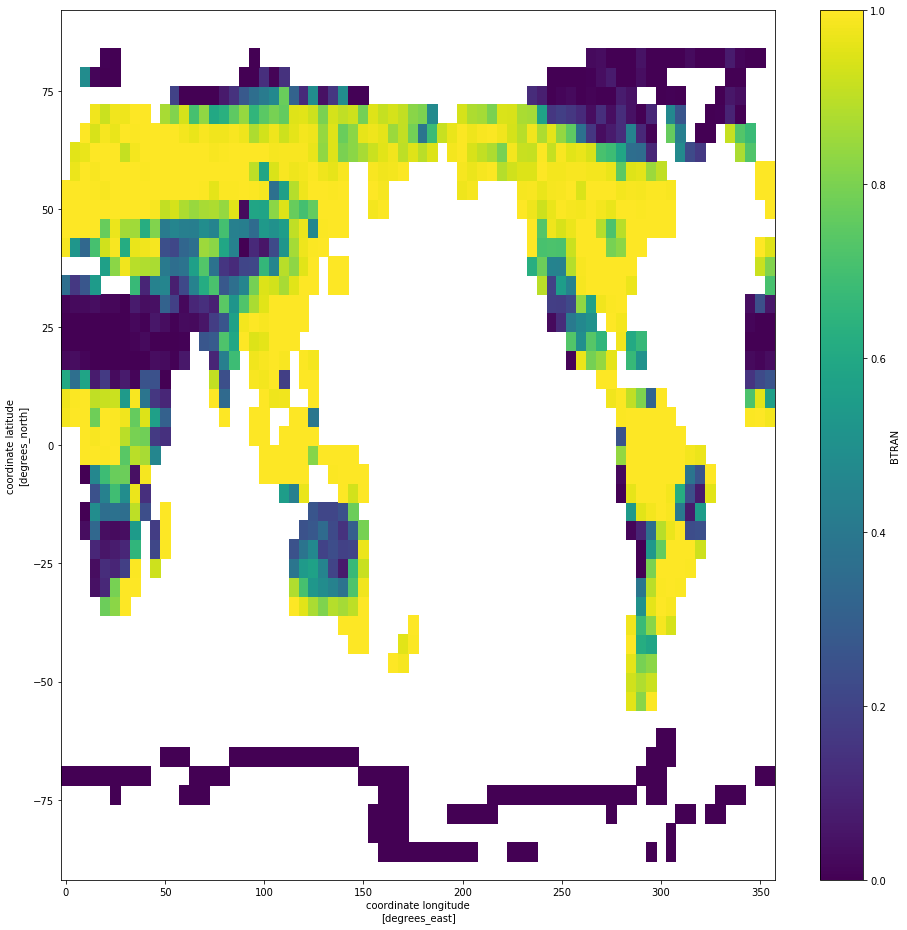

In [6]:
np.mean(ds0.BTRAN,0).plot()

In [7]:
fsurf='/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_4x5_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc'
fsd=xr.open_dataset(fsurf, decode_times=False)
#np.mean(fsd.MONTHLY_HEIGHT_TOP,0).plot(x="lsmlon", y="lsmlat", col="lsmpft", col_wrap=3)


In [8]:
#fsd.PCT_NAT_PFT.plot(x="lsmlon", y="lsmlat", col="natpft", col_wrap=3)
#fsd.PCT_NAT_PFT

In [9]:
amHTOP=np.mean(fsd.MONTHLY_HEIGHT_TOP,0)
#amHTOP.plot(x="lsmlon", y="lsmlat", col="lsmpft", col_wrap=3)

In [10]:
awheight=np.multiply(np.divide(fsd.PCT_NAT_PFT,100),amHTOP)

In [11]:
#fig = plt.figure()
#pfts = range(1,13)
#l1=ds0.PFTleafbiomass
#l0=ds0.PFTleafbiomass
#for p in pfts:
#    ax = fig.add_subplot(4, 4, p)
#    pft0=l1.isel(fates_levpft=p-1)
#    pft0_lat=np.mean(pft0,1)
##    pft0_lat
#    pft0_lat.plot()

    #pft1=l0.isel(fates_levpft=p-1)
    #pft1_lat=np.mean(pft1,1)
    #pft1_lat
    #pft1_lat.plot()


In [12]:
if(allfates==1):
    fig = plt.figure()
    pfts = range(1,13)
    l0=ds0.PFTleafbiomass
    l1=ds1.PFTleafbiomass

    for p in pfts:
        ax = fig.add_subplot(4, 4, p)
        pft0=l0.isel(fates_levpft=p-1)
        pft0_lat=np.mean(pft0,1)
        pft0_lat_lon=np.mean(pft0_lat,1)
        pft0_lat_lon.plot()
    
        pft1=l1.isel(fates_levpft=p-1)
        pft1_lat=np.mean(pft1,1)
        pft1_lat_lon=np.mean(pft1_lat,1)
        pft1_lat_lon.plot()
    
    fnmfig='figs/SP_2rad_'+'lai_ts_'+'_'+str(fg)+'.png'
    plt.savefig(fnmfig)

In [13]:
if(allfates==1):
    fig = plt.figure()
    pfts = range(1,13)
    l1=ds1.PFTbiomass #-ds1.PFTleafbiomass
    l0=ds0.PFTbiomass #-ds0.PFTleafbiomass

    for p in pfts:
        ax = fig.add_subplot(4, 4, p)
        pft0=l0.isel(fates_levpft=p-1)
        pft0_lat=np.mean(pft0,1)
        pft0_lat_lon=np.mean(pft0_lat,1)
        pft0_lat_lon.plot()
    
        pft1=l1.isel(fates_levpft=p-1)
        pft1_lat=np.mean(pft1,1)
        pft1_lat_lon=np.mean(pft1_lat,1)
        pft1_lat_lon.plot()

In [14]:
if(allfates==1):
    fig = plt.figure()
    pfts = range(1,13)
    l1=ds1.PFTgpp #-ds1.PFTleafbiomass
    l0=ds0.PFTgpp #-ds0.PFTleafbiomass
    #print(l1)
    for p in pfts:
        ax = fig.add_subplot(4, 4, p)
        pft0=l0.isel(fates_levpft=p-1)
        pft0_lat=np.mean(pft0,0)
        #print(pft0_lat)
        pft0_lat_lon=np.mean(pft0_lat,1)
        pft0_lat_lon.plot()
    
        pft1=l1.isel(fates_levpft=p-1)
        pft1_lat=np.mean(pft1,0)
        pft1_lat_lon=np.mean(pft1_lat,1)
        pft1_lat_lon.plot()

In [15]:
if(allfates==1):
    fig = plt.figure()
    l1=np.max(ds0.PFTleafbiomass,0)
    l2=np.max(ds1.PFTleafbiomass,0)
    pfts = range(1,13)
    for p in pfts:
       ax = fig.add_subplot(4, 4, p)
       pft0=l1.isel(fates_levpft=p-1)
       pft1=l2.isel(fates_levpft=p-1)   
       diff=pft1-pft0
       diff.plot(cmap='RdYlBu')
       ax.get_xaxis().set_visible(False)
       ax.get_yaxis().set_visible(False)
 
#    fates_pftname =
# 1 "broadleaf_evergreen_tropical_tree          ",
# 2 "needleleaf_evergreen_extratrop_tree        ", X
# 3 "needleleaf_colddecid_extratrop_tree       ",
# 4 "broadleaf_evergreen_extratrop_tree         ",
# 5 "broadleaf_hydrodecid_tropical_tree         ",x
# 6 "broadleaf_colddecid_extratrop_tree        ", X
# 7 "broadleaf_evergreen_extratrop_shrub        ",
# 8 "broadleaf_hydrodecid_extratrop_shrub       ",
# 9 "broadleaf_colddecid_extratrop_shrub       ",
# 10 "arctic_c3_grass                            ",
# 11 "cool_c3_grass                              ",
# 12  "c4_grass

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.29456705, 0.39456705, 0.49456705, 0.59456705, 0.69456705,
        0.79456705, 0.89456705, 0.99456705, 1.09456705, 1.19456705,
        1.29456705]),
 <a list of 10 Patch objects>)

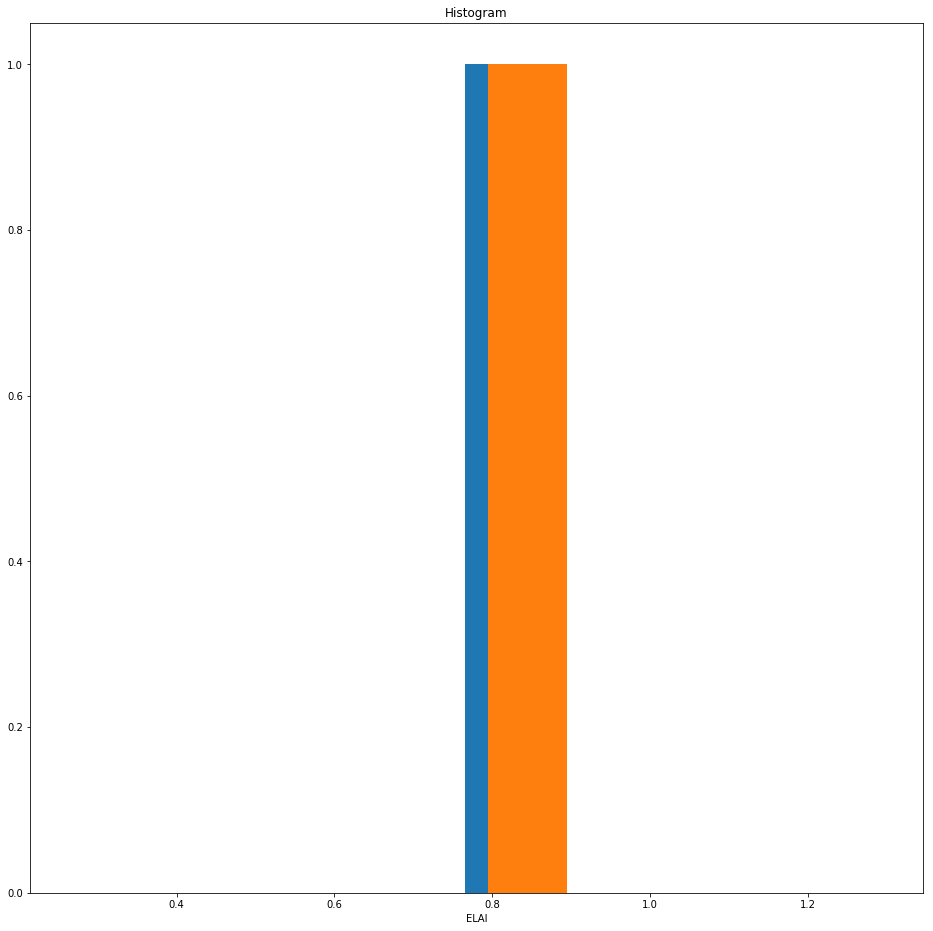

In [16]:
fig = plt.figure()
pfts = range(1,13)
l1=ds1.ELAI
l0=ds0.ELAI

pft0_lat=np.mean(l0,1)
pft0_lat_lon=np.mean(pft0_lat,1)
pft0_lat_lon.plot()
    
pft1_lat=np.mean(l1,1)
pft1_lat_lon=np.mean(pft1_lat,1)
pft1_lat_lon.plot()

In [17]:
if(allfates==1):
    fig = plt.figure()
    b1=np.mean(ds0.PFTnindivs,0)
    b2=np.mean(ds1.PFTnindivs,0)
    pfts = range(1,13)
    for p in pfts:
       ax = fig.add_subplot(4, 4, p)
       pft0=b1.isel(fates_levpft=p-1)
       pft1=b2.isel(fates_levpft=p-1)
       diff=(pft1-pft0)/pft0
       diff.plot(cmap='RdYlBu',vmin=-5,vmax=5)
       ax.get_xaxis().set_visible(False)
       ax.get_yaxis().set_visible(False)

In [18]:
#fig = plt.figure()
#c0=np.mean(ds1.PFTcrownarea,0)
#c1=np.multiply(np.mean(ds1.PFTcrownarea,0),1)
#pfts = range(1,13)
#for p in pfts:
#   ax = fig.add_subplot(4, 4, p)
#   pft0=c0.isel(fates_levpft=p-1)
#   pft1=c1.isel(fates_levpft=p-1)   
#   diff=(pft1-pft0)
#   diff.plot()
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)

#### Plotting function

In [19]:
def plot_fn(dinput, figh,figw,nc,nr,runlabel,vmd,vmx,var,varname,absdiff):
    fig = plt.figure()
    lfont=20
    tfont=24
    plt.rcParams['figure.figsize'] = [figh,figw] 
    for i,d in enumerate(dinput,start=0):
        if(i<4):
            print(i)
            ax = fig.add_subplot(nr,nc, i+1)
            im=np.mean(d,0).plot(vmin=0,vmax=vmx,add_colorbar=False)
            ax.set_title(var+'_'+runlabel[i],fontsize=tfont)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            cb = plt.colorbar(im, orientation="vertical")
            cb.set_label(label=varname, size=tfont, weight='bold')
            cb.ax.tick_params(labelsize='large')
        
    ax3 = fig.add_subplot(nr,nc, 3)
    if(absdiff==0):
        diff=100*(np.mean(dinput[1],0)-np.mean(dinput[0],0))/np.mean(dinput[0],0)
        lab='$\Delta$ (%)'
        titl=var+'_'+'(2-1)/1'
    else:
        diff=np.mean(dinput[1],0)-np.mean(dinput[0],0)
        lab='$\Delta$ (absolute)'
        titl=var+'_'+'(2-1)'
        
    if(absdiff==0):
        im = diff.plot(vmin=-100*vmd,vmax=100*vmd,add_colorbar=False,cmap='RdYlBu')   
    else:
        im = diff.plot(vmin=-vmd,vmax=vmd,add_colorbar=False,cmap='RdYlBu')
    ax3.set_title(titl,fontsize=tfont)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    cb = plt.colorbar(im, orientation="vertical")    
    cb.set_label(label=lab, size=lfont, weight='bold')
    cb.ax.tick_params(labelsize='large')
  
    
    fnmfig='figs/SP_2rad_'+var+'_'+str(fg)+'.png'
    
    
    #print(fnmfig)
    plt.savefig(fnmfig)

### BIOMASS plot

In [20]:
print(conv3)
#plot_fn(dBIOMASS,figh,figw,nc,nr,runlabel,0.4,3,'Biomass','Biomass: MgC ha$^1$',1)

0.01


### AREA PLANT plot

In [21]:
#print(conv3)
#plot_fn(dAREAPLANT,figh,figw,nc,nr,runlabel,0.1,1,'AREA_PLANT','AREA_PLANT: m$^2$',0)

### ERROR plot

In [22]:
#plot_fn(dERR,figh,figw,nc,nr,runlabel,0.05,0.0000001,'ERR','ERROR',0)

### TOTRAD plot

0
1


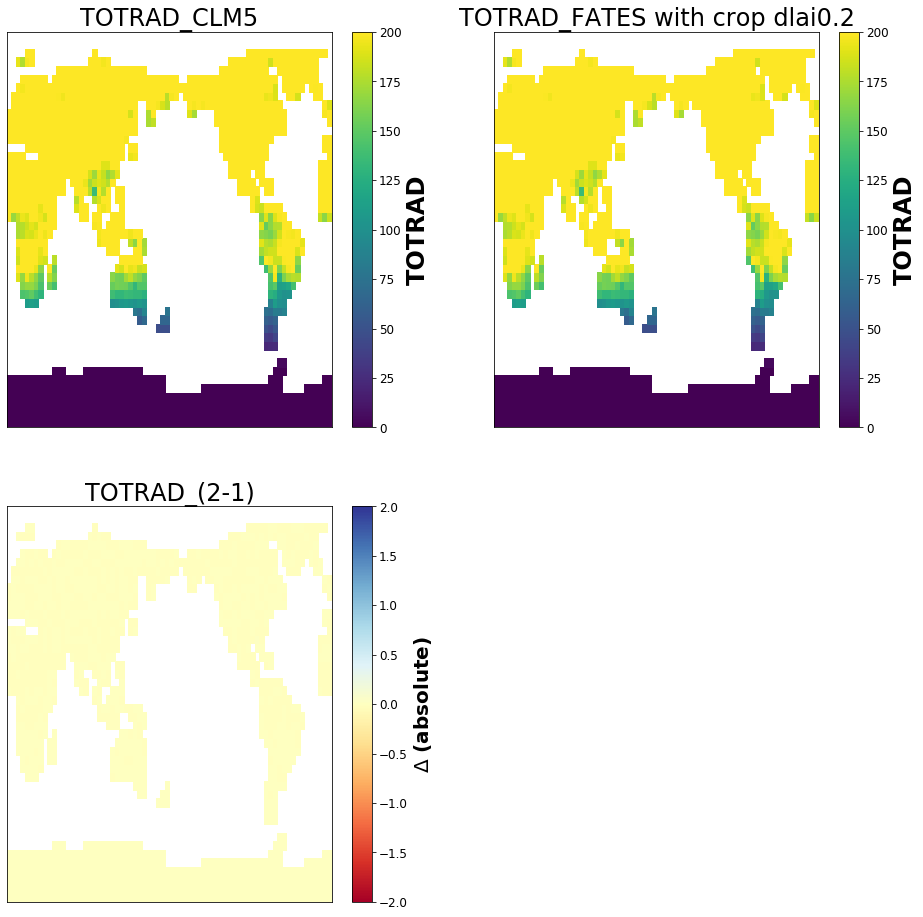

In [23]:
plot_fn(dTOTRAD,figh,figw,nc,nr,runlabel,2,200,'TOTRAD','TOTRAD',1)

### FCEV plot

In [24]:
#plot_fn(dFCEV,figh,figw,nc,nr,runlabel,10,40,'FCEV','Canopy evap Wm$^2$',1)

### SNOW plot

0
1


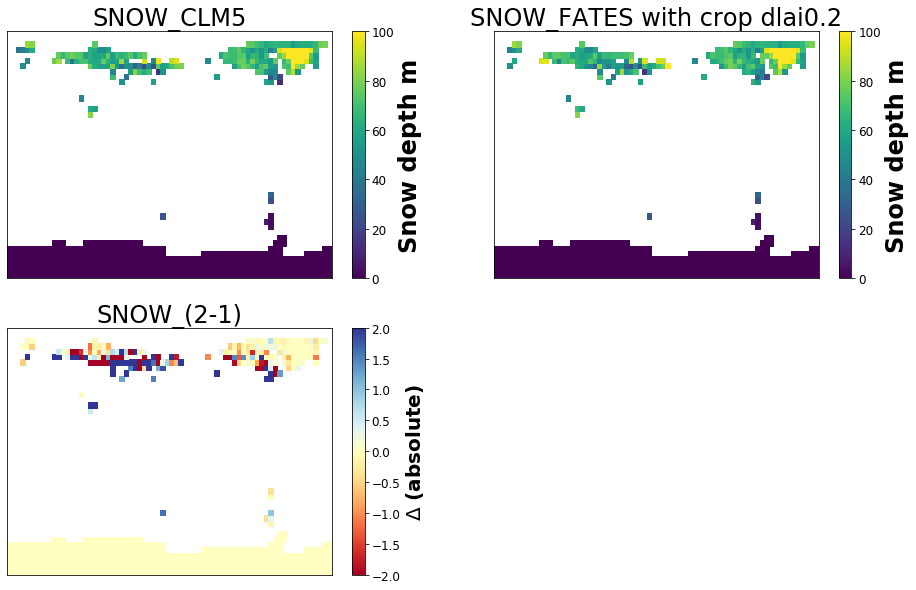

In [25]:
#plot_fn(dSNOW,figw,nc,nr,runlabel,0.1,2,'SNOW','Snow Depth m',1)
plot_fn(dSNOW,figh,figw,nc,nr,runlabel,2,100,'SNOW','Snow depth m',1)

### FSDS plot

0
1


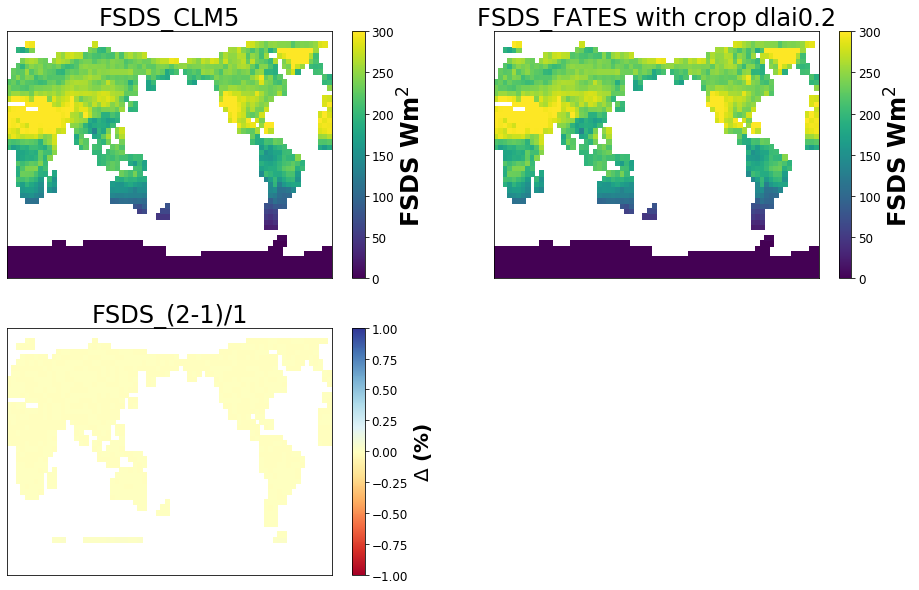

In [26]:
plot_fn(dFSDS,figh,figw,nc,nr,runlabel,0.01,300,'FSDS','FSDS Wm$^2$',absdiff)

0
1


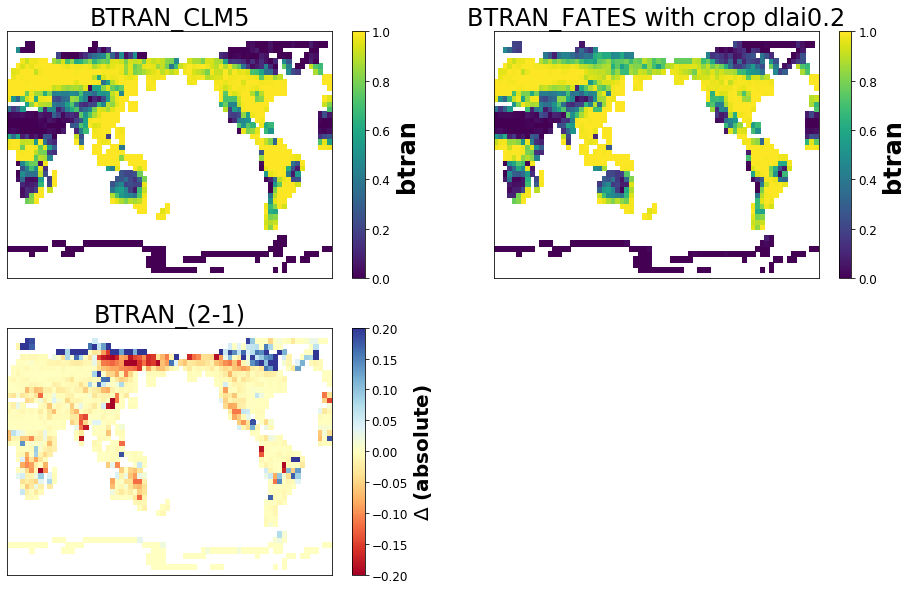

In [27]:
plot_fn(dBTRAN,figh,figw,nc,nr,runlabel,0.2,1,'BTRAN','btran',1)

### ET plot

In [28]:
#plot_fn(dET,figh,figw,nc,nr,runlabel,0.1,5,'ET','ET mm day$^2$',absdiff)

### QVEGE plot

In [29]:
#plot_fn(dQVEGE,figh,figw,nc,nr,runlabel,0.3,1.5,'QVEGE','Canopy evap mm day$^2$',absdiff)

### QVEGT plot

In [30]:
#plot_fn(dQVEGT,figh,figw,nc,nr,runlabel,0.5,4,'QVEGT','Transpiration mm day$^2$',absdiff)

### FSR plot

0
1


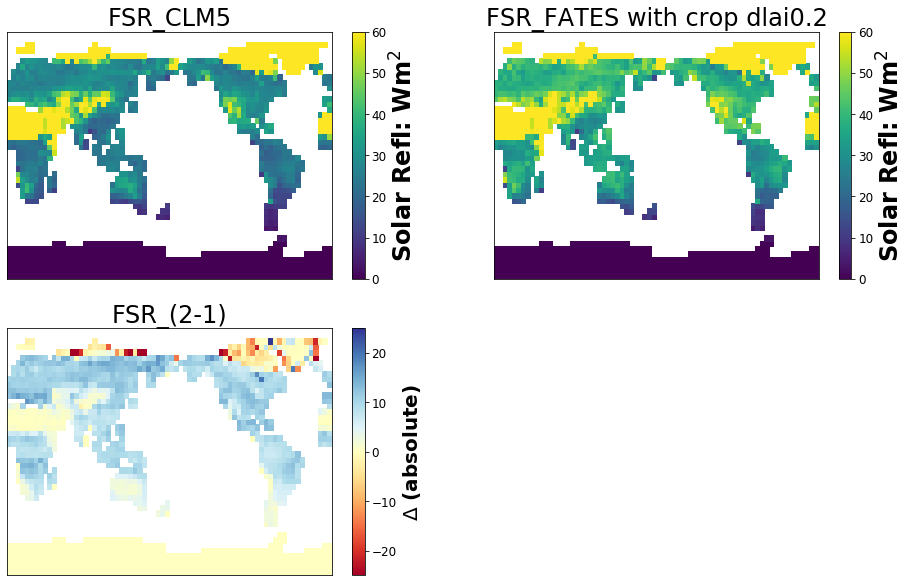

In [31]:
plot_fn(dFSR,figh,figw,nc,nr,runlabel,25,60,'FSR','Solar Refl: Wm$^2$',1)

### FGR plot

0
1


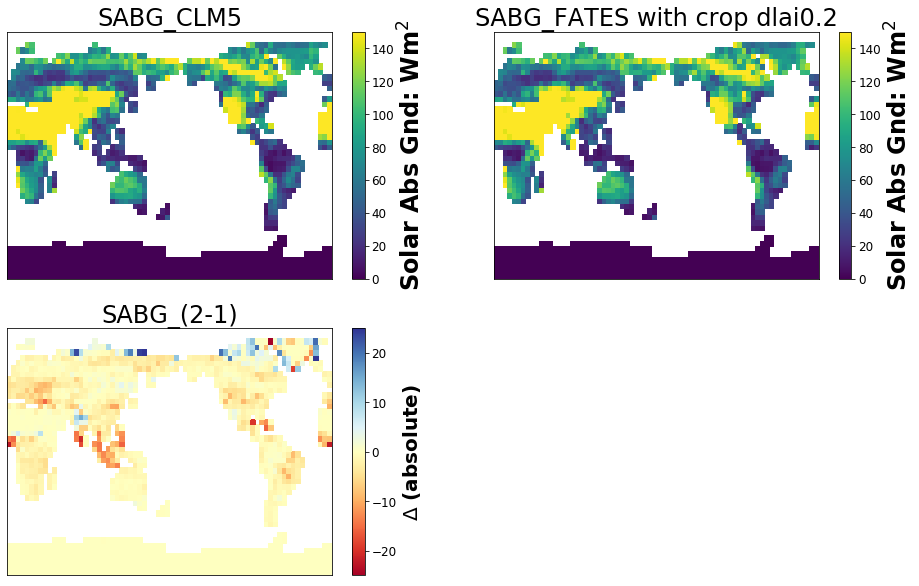

In [32]:
plot_fn(dSABG,figh,figw,nc,nr,runlabel,25,150,'SABG','Solar Abs Gnd: Wm$^2$',1)

### SABV plot

0
1


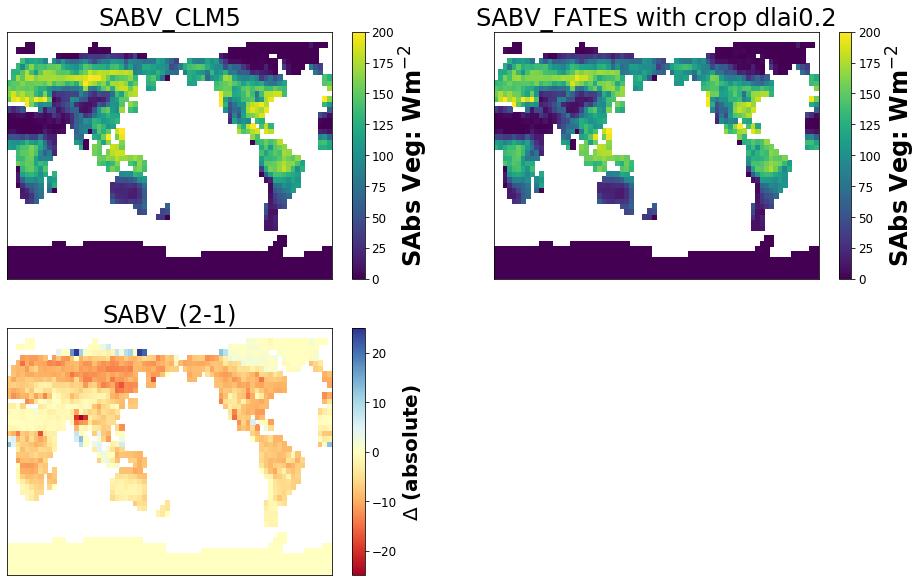

In [33]:
plot_fn(dSABV,figh,figw,nc,nr,runlabel,25,200,'SABV','SAbs Veg: Wm$^{-2}$',1)

### LUE plot

0
1


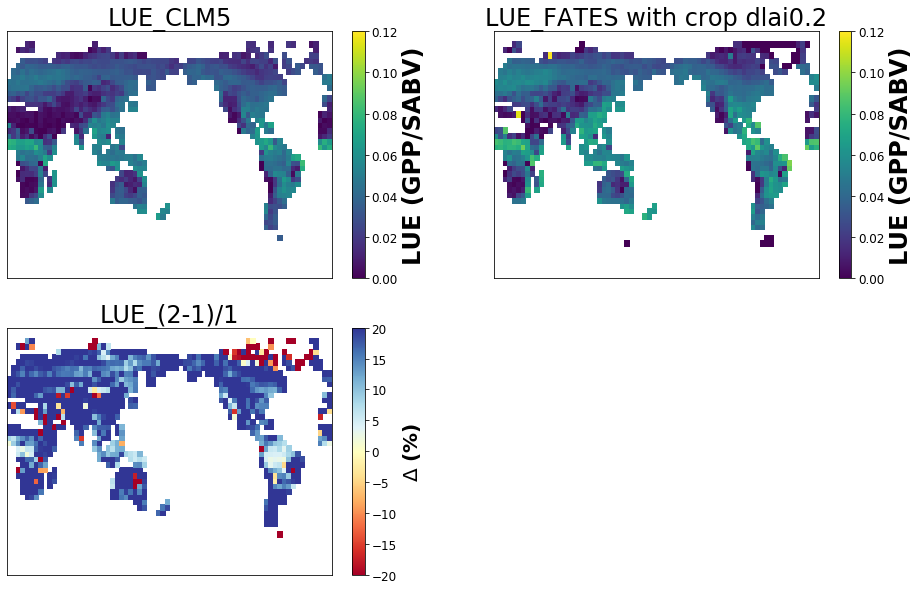

In [34]:
plot_fn(dlue,figh,figw,nc,nr,runlabel,0.2,0.12,'LUE','LUE (GPP/SABV)',0)

### HTOP plot

In [35]:
#plot_fn(dHTOP,figh,figw,nc,nr,runlabel,0.3,20,'HTOP','HTOP',0)

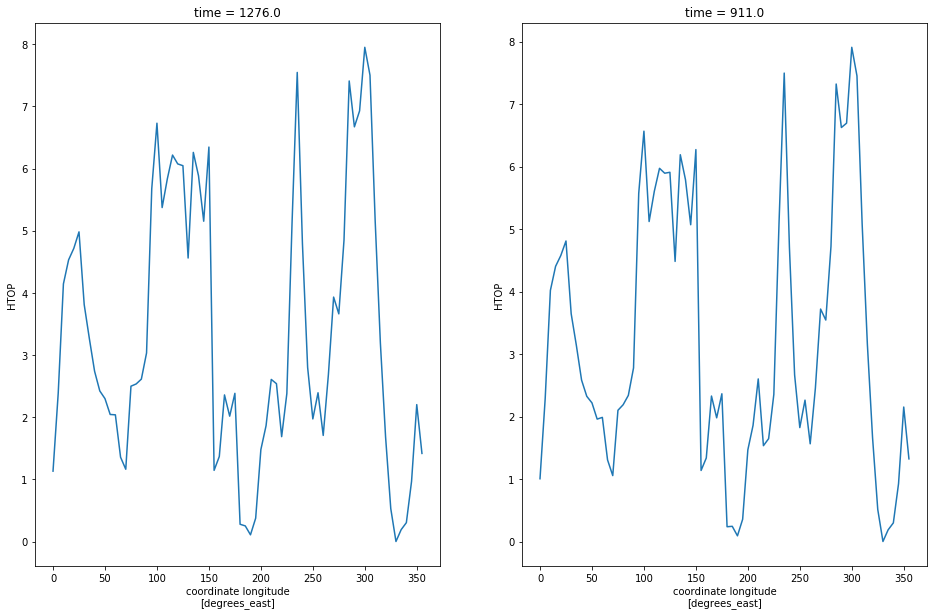

In [36]:
fig = plt.figure()
pfts = range(1,13)
l1=ds1.HTOP
l0=ds0.HTOP
ax = fig.add_subplot(1, 2, 1)
pft0_lat=np.mean(l0,1)
pft0_lat_lon=np.mean(pft0_lat,1)
pft0_lat.plot()

ax = fig.add_subplot(1, 2, 2)   
pft1_lat=np.mean(l1,1)
pft1_lat_lon=np.mean(pft1_lat,1)
pft1_lat.plot()

0
1


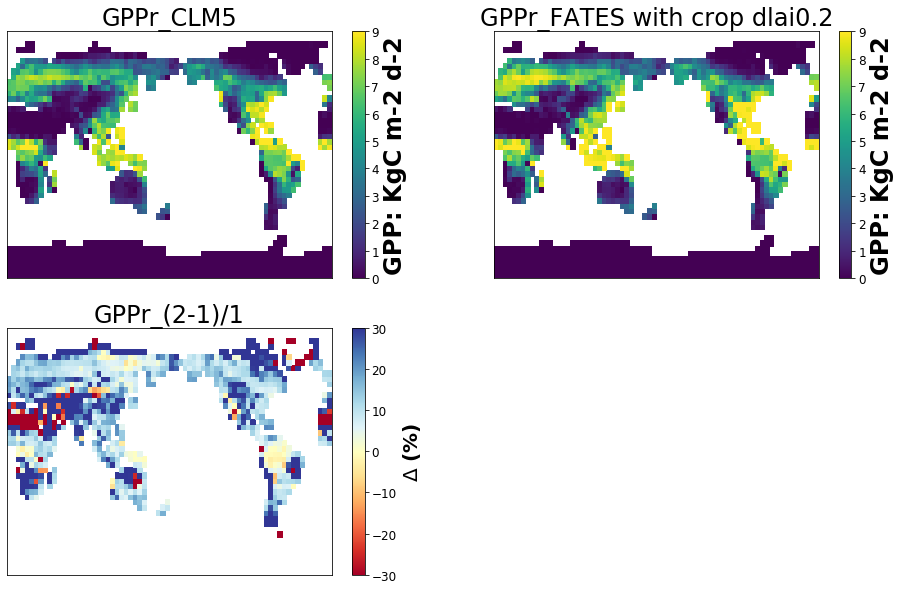

In [37]:
plot_fn(dGPP,figh,figw,nc,nr,runlabel,0.3,9,'GPPr','GPP: KgC m-2 d-2',0)

### NPP plot

In [38]:
#plot_fn(dNPP,figh,figw,nc,nr,runlabel,0.2,5,'NPP','NPP: KgC m-2 d-2',0)

In [39]:
dwue

[<xarray.DataArray (time: 1, lat: 46, lon: 72)>
 dask.array<shape=(1, 46, 72), dtype=float64, chunksize=(1, 46, 72)>
 Coordinates:
   * time     (time) float32 1276.0
   * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
   * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0,
 <xarray.DataArray (time: 1, lat: 46, lon: 72)>
 dask.array<shape=(1, 46, 72), dtype=float64, chunksize=(1, 46, 72)>
 Coordinates:
   * time     (time) float32 911.0
   * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
   * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0]

### WUE plot

0
1


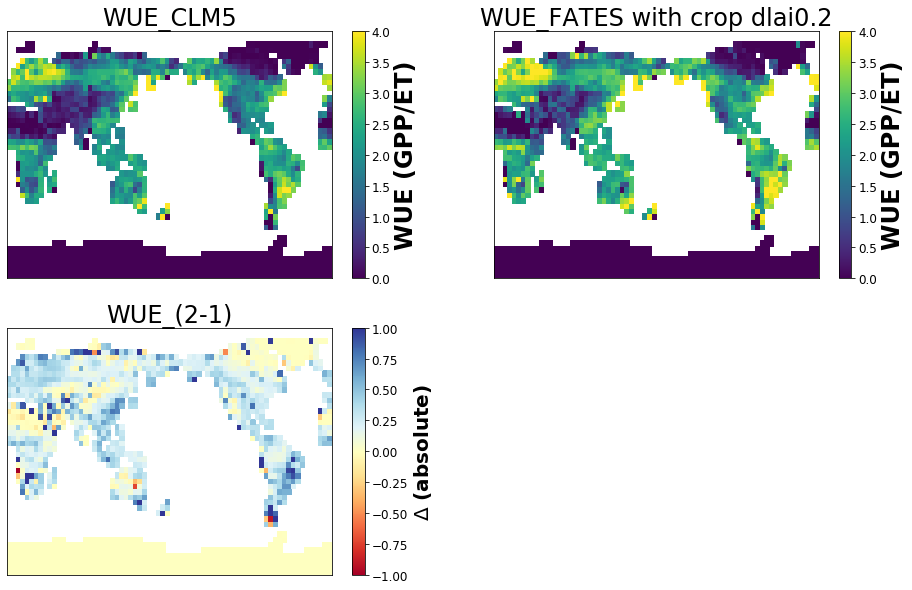

In [40]:
plot_fn(dwue,figh,figw,nc,nr,runlabel,1,4,'WUE','WUE (GPP/ET)',1)

### TLAI plot

0
1


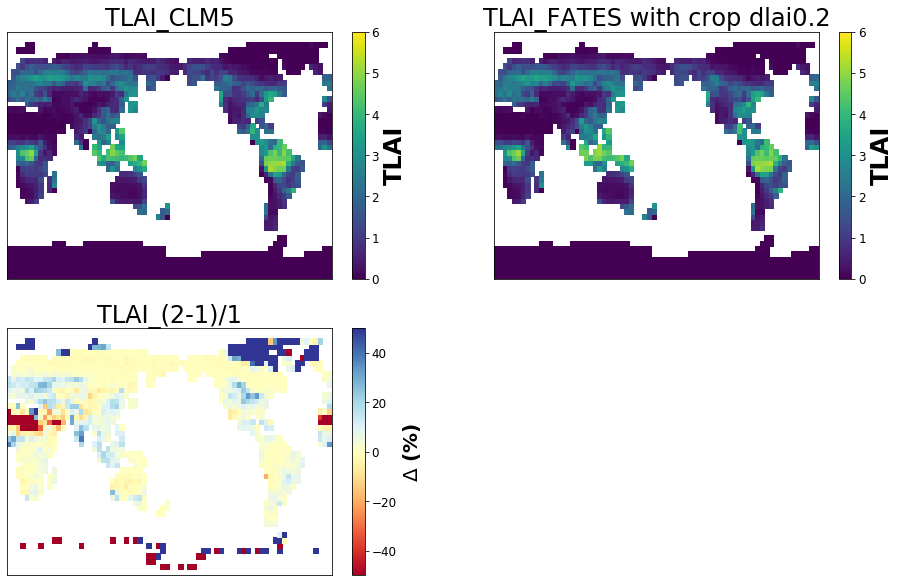

In [41]:
plot_fn(dTLAI,figh,figw,nc,nr,runlabel,0.5,6,'TLAI','TLAI',0)

### ELAI plot

0
1


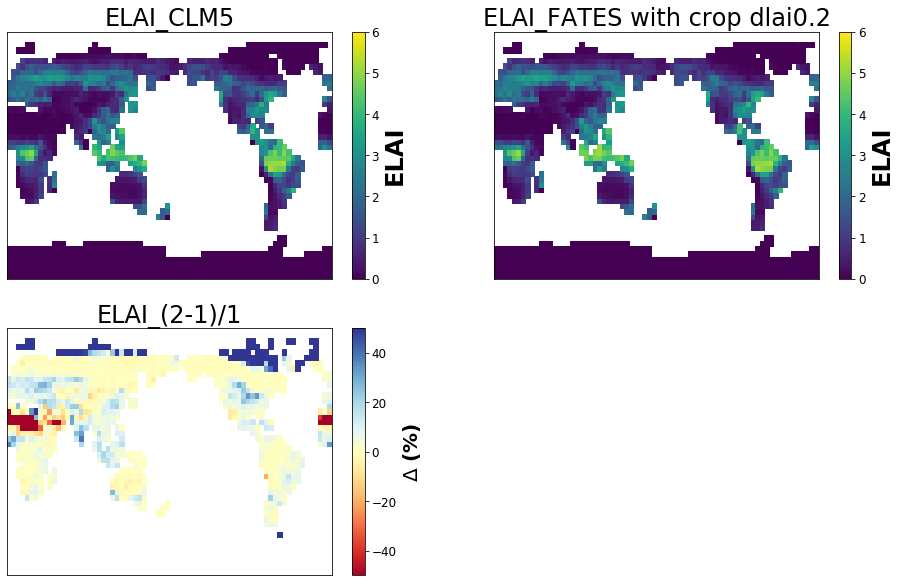

In [42]:
plot_fn(dELAI,figh,figw,nc,nr,runlabel,0.5,6,'ELAI','ELAI',0)

### ESAI plot

0
1


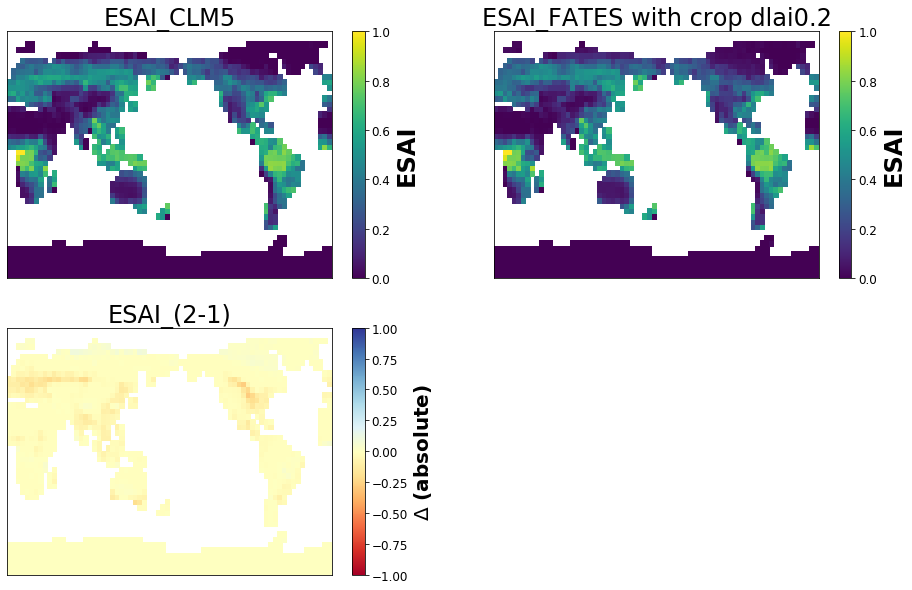

In [43]:
plot_fn(dESAI,figh,figw,nc,nr,runlabel,1,1.0,'ESAI','ESAI',1)

### TSAI plot

0
1


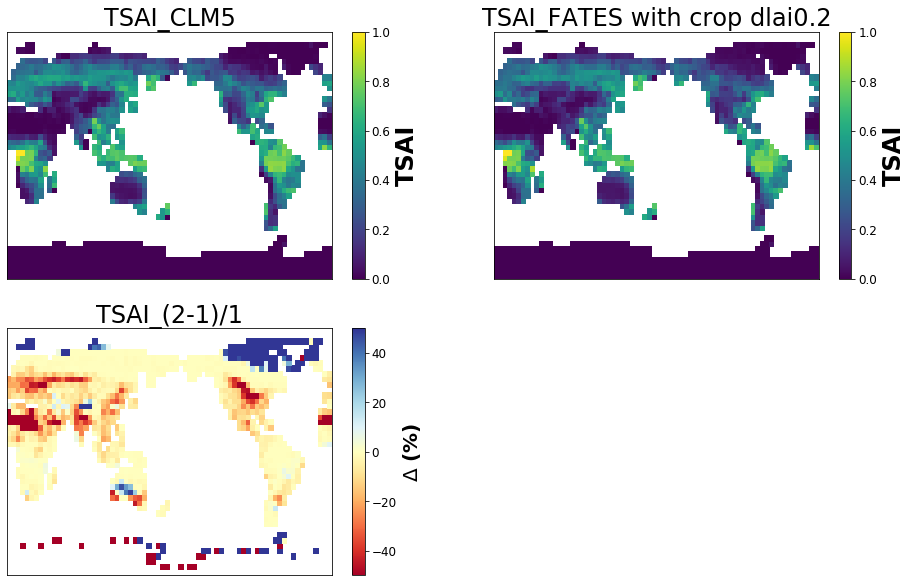

In [44]:
plot_fn(dTSAI,figh,figw,nc,nr,runlabel,0.5,1.0,'TSAI','TSAI',0)

### SH plot

0
1


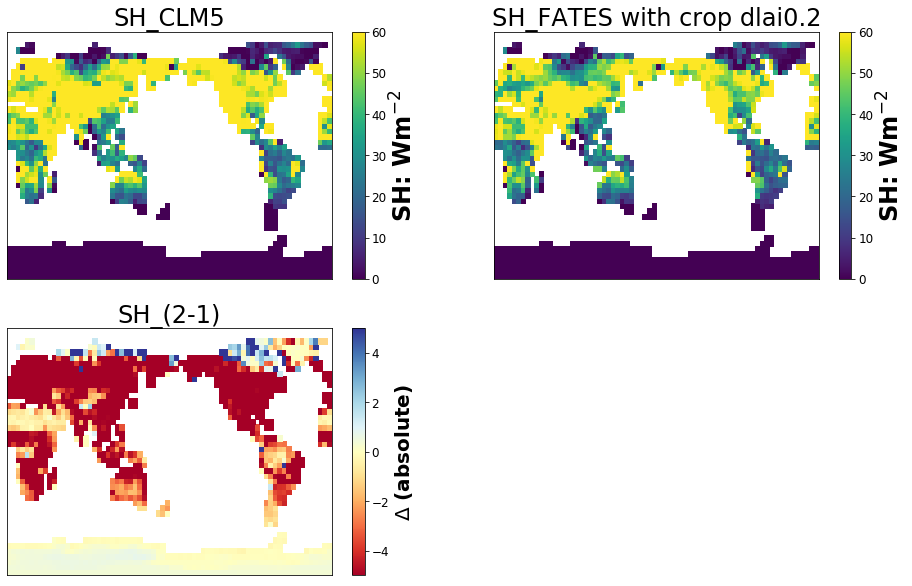

In [45]:
plot_fn(dSH,figh,figw,nc,nr,runlabel,5,60,'SH','SH: Wm$^{-2}$',1)

### TV plot

0
1


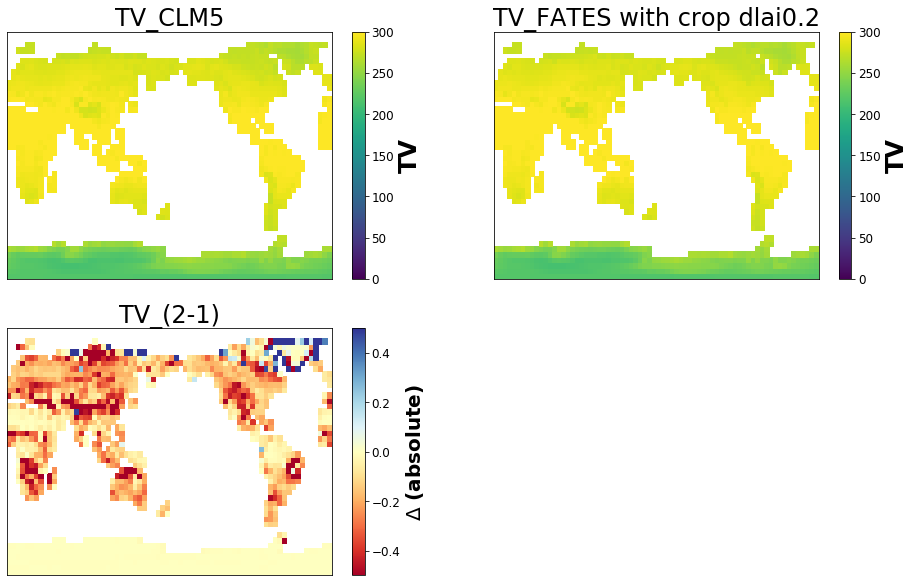

In [46]:
plot_fn(dTV,figh,figw,nc,nr,runlabel,0.5,300,'TV','TV',1)

### LH+SH

0
1


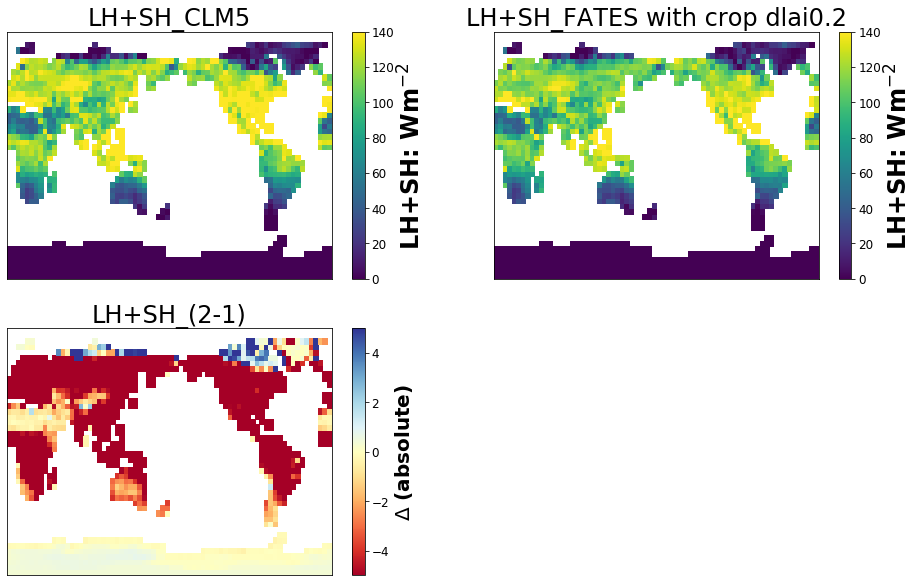

In [47]:
plot_fn(dLHSH,figh,figw,nc,nr,runlabel,5,140,'LH+SH','LH+SH: Wm$^{-2}$',1)

### LH

0
1


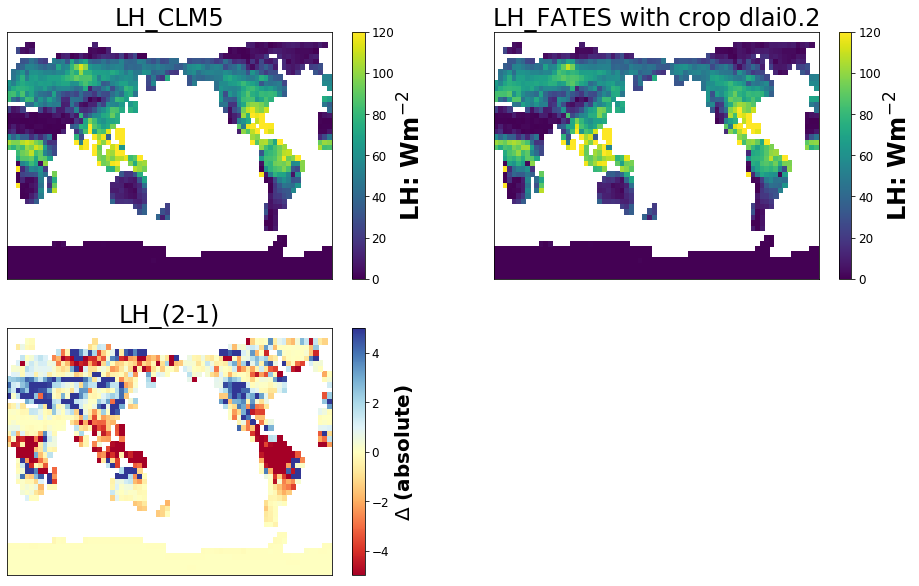

In [48]:
plot_fn(dLH,figh,figw,nc,nr,runlabel,5,120,'LH','LH: Wm$^{-2}$',1)

0
1


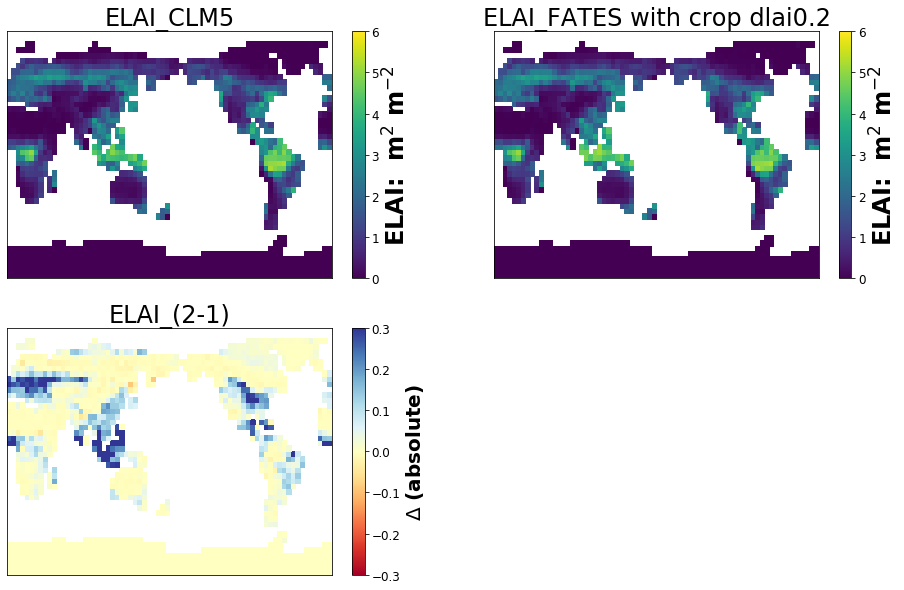

In [49]:
plot_fn(dELAI,figh,figw,nc,nr,runlabel,0.3,6,'ELAI','ELAI:  m$^{2}$ m$^{-2}$',1)

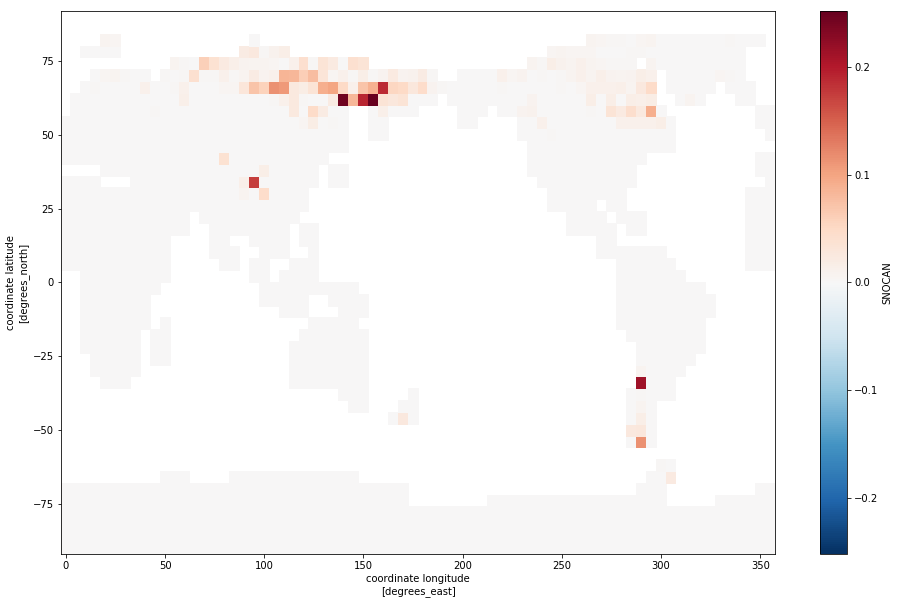

In [50]:
np.max(ds1.SNOCAN,0).plot()

### LH

### Bowen Ratio

0
1


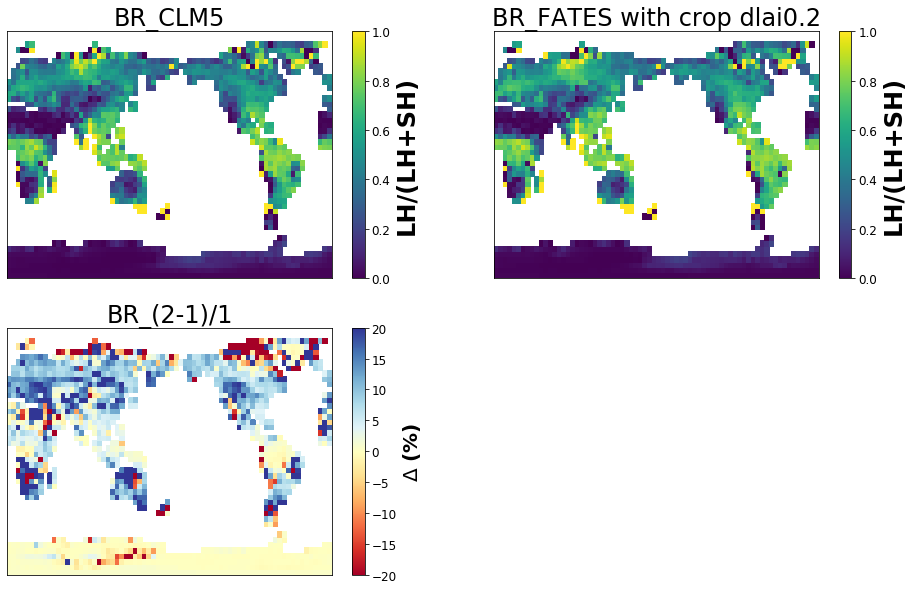

In [51]:
dBR=[]
for i,d in enumerate(dLH,start=0):
    dBR.append(np.divide(d,(d+dSH[i])))
plot_fn(dBR,figh,figw,nc,nr,runlabel,0.20,1,'BR','LH/(LH+SH)',0)

### Stomatal Conductance

In [52]:
cratio=np.divide(np.mean(dsF.C_STOMATA ,0),(np.mean(dsF.C_STOMATA ,0)+np.mean(dsF.C_LBLAYER ,0)))
#cratio.plot(vmin=0,vmax=0.1)


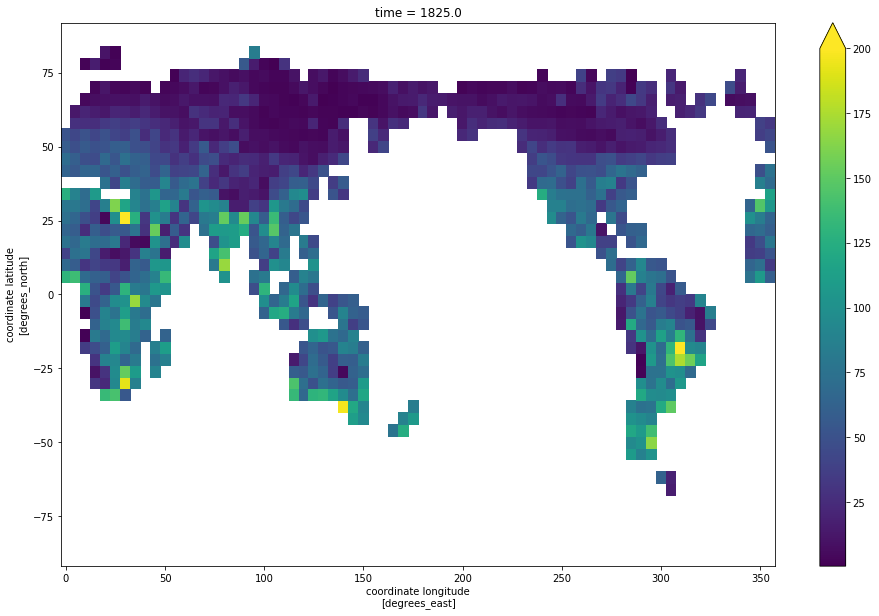

In [53]:
deff='/glade/scratch/rfisher/seb_CLM5-SP_def/run/seb_CLM5-SP_def.clm2.h0.2004-12.nc'
dsdef=xr.open_dataset(deff, decode_times=False)  
fracsunl=np.divide(dsdef.LAISUN,dsdef.LAISUN+dsdef.LAISHA)
gscanopy=np.multiply(dsdef.GSSUN,fracsunl)+np.multiply(dsdef.GSSHA,1-fracsunl)
gscanopy=np.divide(gscanopy,1000)
gscanopy.plot(vmax=200)

## SABV from ELAI

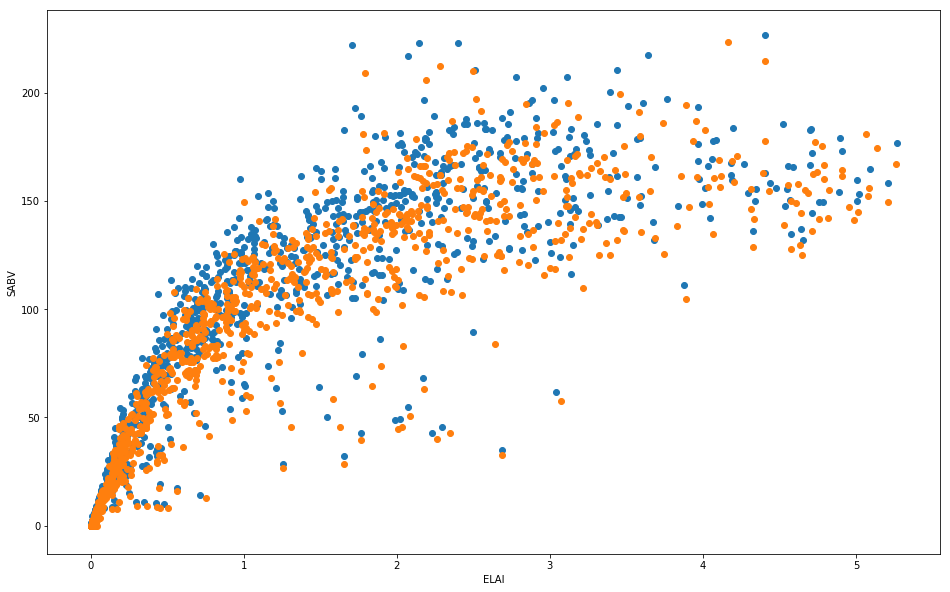

In [54]:
plt.scatter(ds0.ELAI,ds0.SABV)
plt.scatter(ds1.ELAI,ds1.SABV)
plt.ylabel("SABV")
plt.xlabel("ELAI")
fnmfig='figs/SP_2rad_'+'elai_vs_sabv'+'_'+str(fg)+'.png'
plt.savefig(fnmfig)


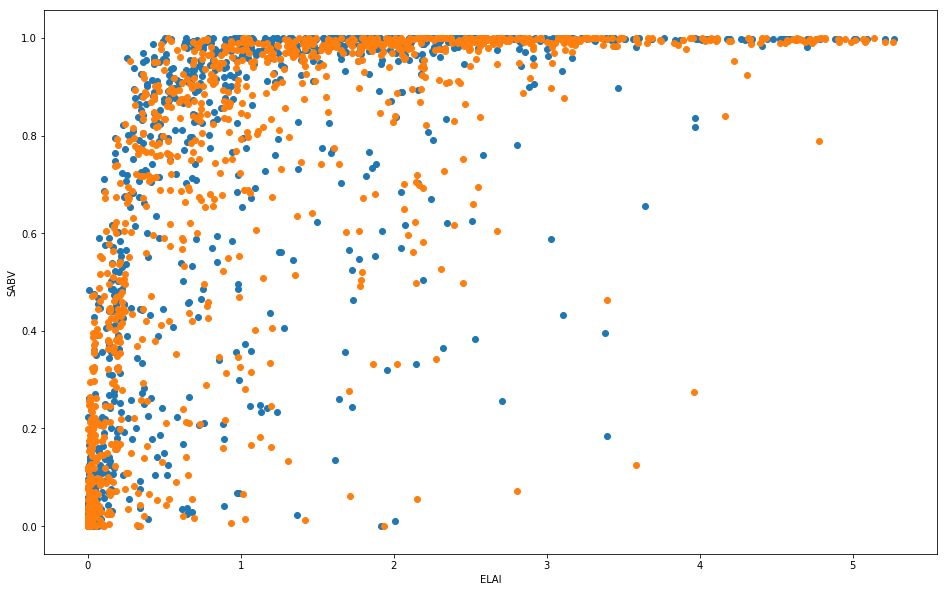

In [55]:
plt.scatter(ds0.ELAI,ds0.BTRAN)
plt.scatter(ds1.ELAI,ds1.BTRAN)
plt.ylabel("SABV")
plt.xlabel("ELAI")
fnmfig='figs/SP_2rad_'+'elai_vs_sabv'+'_'+str(fg)+'.png'
plt.savefig(fnmfig)

## TLAI from bleaf

In [56]:
plt.scatter(ds0.ED_bleaf,ds0.ELAI)
plt.scatter(ds1.ED_bleaf,ds1.ELAI)
fnmfig='figs/SP_2rad_'+'lai_vs_bleaf'+'_'+str(fg)+'.png'
plt.savefig(fnmfig)

AttributeError: 'Dataset' object has no attribute 'ED_bleaf'

## GPP from SABV

In [ ]:
plt.scatter(ds0.ELAI,ds0.GPP)
plt.scatter(ds1.ELAI,ds1.GPP)
plt.ylim([ 0,0.0002])
plt.xlabel("ELAI")
plt.ylabel("GPP")
fnmfig='figs/SP_2rad_'+'elai_vs_gpp'+'_'+str(fg)+'.png'
plt.savefig(fnmfig)

In [ ]:
ds1

##### 